In [1]:
import cv2
import geom
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import namedtuple
from geom_cv2 import four_point_transform
from sklearn.cluster import KMeans

from util import slicetool
from geom import Point2

In [2]:
"""Just for drawing."""

def show_image(img):
    opt = {}
    if len(img.shape) < 3:
        opt.update(cmap="gray")
    plt.imshow(img, **opt)
    plt.show()
    

def get_segment(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    return Point2(x=x1, y=y1), Point2(x=x2, y=y2)


def add_lines(lines, image, *line_args):
    img_ = image.copy()
    for line, in lines:
        rho, theta = line
        p1, p2 = get_segment(rho, theta)
        img_ = cv2.line(img_, p1, p2, *line_args)
    return img_


def show_lines(lines, image):
    n = len(lines)
    s = int(math.ceil(math.sqrt(n)))

    plt.figure()
    for k, line in enumerate(lines):
        img_with_line = add_lines([line], image, (255, 0, 0), 5)
        plt.subplot(s, s, k + 1)
        plt.imshow(img_with_line)
        
    plt.show()

    
from util_cv2 import resize

In [3]:
image_dir = "../data/set_data/my_cards/test"
image_files = sorted(fn for fn in os.listdir(image_dir) if fn.endswith(".jpg"))
image_files = [os.path.join(image_dir, fn) for fn in image_files]

instances = [
    (image_files[0], slicetool[600:1500, 0:850]),
    (image_files[10], slicetool[1100:2000, 250:750]),
    (image_files[1], slicetool[1000:2000,:1000]),
    (image_files[1], slicetool[1000:2000,1000:]),
    (image_files[25], slicetool[1500:2750,250:1000]),
    # (image_files[25], slicetool[:,:]),
]

len(image_files)

26

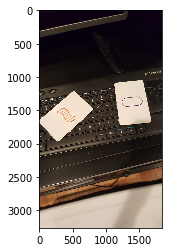

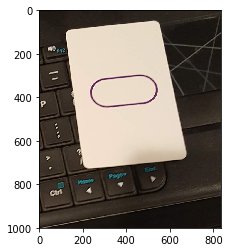

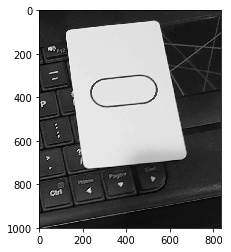

In [4]:
img_fn, card_slice = instances[-2]
img = cv2.imread(img_fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

card1 = img[card_slice]
card1_ = cv2.cvtColor(card1, cv2.COLOR_RGB2GRAY)

show_image(img)
show_image(card1)
show_image(card1_)

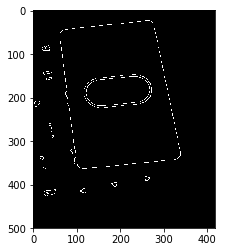

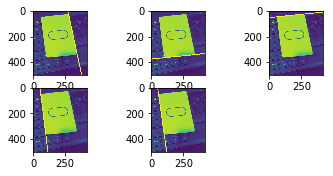

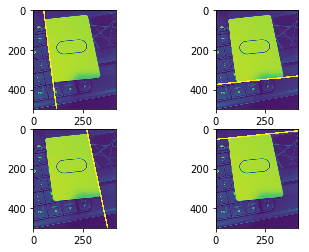

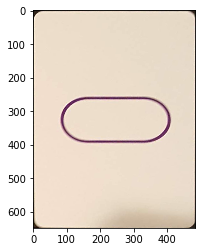

5

In [5]:
import detect
ld = detect.LocalCardDetector()

resized, canny, ratio = ld.detect_edges(card1_)
show_image(canny)

lines = ld.get_lines(canny)
show_lines(lines[:10], resized)


if True:
    lines_ = ld._filter_lines(lines)
    show_lines(lines_, resized)

if False:
    color = (255, 0, 0)

    for box in ld.get_boxes(canny):
        boxed = card1.copy()
        poly = box.reshape((4, 2))  # ?
        cv2.polylines(boxed, [poly], True, color, 10)
        show_image(boxed)

        warped = ld.warp(card1, box)
        show_image(warped)

# KMeans clustering may have succeeded in throwing away slivers...

det = ld.detect(card1)
show_image(det)

len(lines)

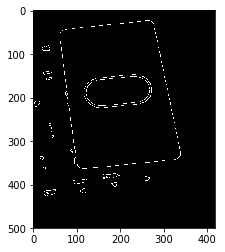

In [6]:
_, canny, ratio = ld.detect_edges(card1)
show_image(canny)
lines = ld.get_lines(canny)
lines_ = ld._filter_lines(lines)

#cycle = lines_[:] + lines_[:1,:]
# cycle
#points = [intersection(*pair) for pair in zip(cycle[:-1], cycle[1:])]
#points

#boxes = list(ld.get_boxes(canny))
#boxes, lines_
#pair = list(zip(cycle[:-1], cycle[1:]))[0]
#pair

#intersection(*pair)

In [7]:
# Another cool line detector.. median blur?
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv/46572063
if False:
    import cv2
    import numpy as np

    img = cv2.imread('sudoku.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    thresh_type = cv2.THRESH_BINARY_INV
    bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)

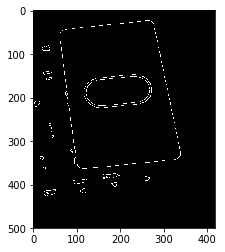

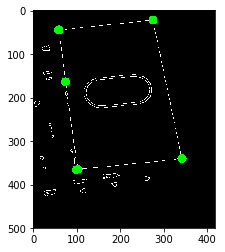

[[[342, 340]],
 [[275, 22]],
 [[-240, -2400]],
 [[-375, -3033]],
 [[99, 366]],
 [[103, 365]],
 [[60, 45]],
 [[58, 45]],
 [[74, 164]]]

In [8]:
import itertools
import geom

canny_ = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)

pointed = canny_.copy()
show_image(pointed)
points = [geom.intersection(l1, l2) for l1, l2 in itertools.combinations(lines, 2)]
points = [p for p in points if p is not None]

if True:
    for point, in points:
        cv2.circle(pointed, tuple(point), 10, (0,255,0), -1)

    # rect = cv2.minAreaRect(card_contour)  # perspective transform is better.
    show_image(pointed)

points
# Already a problem... but we can do some box detection...?

In [20]:
import os
image_path = os.path.abspath("../../PROJECT/data/set_data/my_cards/test/")
image_files = [os.path.join(image_path, fn) for fn in os.listdir(image_path) if fn.endswith(".jpg")]

from rectify_images import ObjectsImage, get_objects

if False:
    # list(get_objects(image_files[0]))
    # img = cv2.imread(image_files[0])

    image_index = 1

    oi = ObjectsImage(image_files[image_index])

    I = dict(get_objects(image_files[image_index]))
    show_image(oi.image)
    for i in I.values():
        show_image(i)
        show_image(ld.detect(i))

    # oi.image_file, oi.xml_file, oi.slices

    img = oi.image

    #x = ET.parse(oi.xml_file)
    # x.getchildren()
from detect import LocalCardDetector
ld = LocalCardDetector()
    
def write_objects(image_path, target_path, *, class_fn=None, detect=False):
    os.makedirs(target_path)
    
    image_files = [os.path.join(image_path, fn) for fn in os.listdir(image_path) if fn.endswith(".jpg")]
    for imgf in image_files:
        oi = ObjectsImage(imgf)
        img = oi.image
        fn = oi.image_name
        for k, obj in enumerate(oi.objects):
            slice_, klass = obj
            klass_ = class_fn(klass) if class_fn else klass

            out_dir = os.path.join(target_path, klass_)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)

            img_ = img[slice_]
            if detect:
                img_ = ld.detect(img_)

            fn_ = "{}_{}.jpg".format(fn, k)
            out_file = os.path.join(out_dir, fn_)
            # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.misc.imsave.html
            import matplotlib.pyplot as plt
            plt.imsave(out_file, img_)

            
def get_color(klass):
    return klass.split("-")[1]


write_objects(image_path, "path/to", class_fn=get_color, detect=True)

TypeError: Image data cannot be converted to float

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_df(image_files):
    xml_list = []
    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]
        xml_file = "{}.xml".format(image_name)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj_idx, member in enumerate(root.findall('object')):
            value = (image_name,
                     obj_idx,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['image_name', "object_index", 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

"""
def main():
    for folder in ['train','test']:
        image_path = os.path.join(os.getcwd(), ('images/' + folder))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv(('images/' + folder + '_labels.csv'), index=None)
        print('Successfully converted xml to csv.')

main()
"""

df = xml_to_df(image_files)

In [ ]:
df[df.image_name == '/app/data/PROJECT/data/set_data/my_cards/test/20191028_210622.jpg']
df

In [ ]:
np.arange(10)[::-1]
np.eye(3).transpose()